In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Survival modeling
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time


In [2]:

# -----------------------------
# 1) Simulate data (historical placebo + current treated)
# -----------------------------
rng = np.random.default_rng(42)

def simulate_time_to_event(n, beta, hazard_scale=0.02, admin_censor_time=24.0):
    """
    Simulate survival times under an exponential baseline hazard with covariate effects.
    Also add random censoring + administrative censoring.
    Returns dataframe with: time, event, covariates.
    """
    # Covariates (simple + interpretable)
    age = rng.normal(60, 10, size=n)                # years
    sev = rng.normal(0, 1, size=n)                  # disease severity z-score
    sex = rng.integers(0, 2, size=n)                # 0/1

    # Linear predictor
    # beta dict: {"age": ..., "sev": ..., "sex": ...}
    lp = beta["age"]*(age - 60)/10 + beta["sev"]*sev + beta["sex"]*sex

    # Exponential hazard: h = hazard_scale * exp(lp)
    # For exponential model, T = -log(U) / h
    U = rng.uniform(size=n)
    hazard = hazard_scale * np.exp(lp)
    true_time = -np.log(U) / hazard

    # Random censoring time (e.g., loss to follow-up)
    censor_time = rng.exponential(scale=30.0, size=n)  # average 30 months

    # Administrative censoring at fixed study end
    admin_censor = np.full(n, admin_censor_time)

    observed_time = np.minimum.reduce([true_time, censor_time, admin_censor])
    event = (true_time <= observed_time).astype(int)

    return pd.DataFrame({
        "time": observed_time,
        "event": event,
        "age": age,
        "sev": sev,
        "sex": sex
    })


In [3]:

# "True" placebo data-generating process
beta_placebo = {"age": 0.35, "sev": 0.60, "sex": 0.10}


In [5]:

# Historical placebo dataset (train model here)
hist_placebo = simulate_time_to_event(n=1500, beta=beta_placebo, hazard_scale=0.02, admin_censor_time=24)
hist_placebo.head(3)

,time,event,age,sev,sex
0,9.708018,1,46.749404,0.497287,0
1,16.707297,1,76.154303,-0.819429,0
2,20.989338,1,49.834894,1.279688,0


In [6]:

# Current trial treated arm:
# Suppose treatment reduces hazard by ~30% (HR=0.70) on average.
# We'll simulate that by lowering the baseline hazard_scale.
treated = simulate_time_to_event(n=300, beta=beta_placebo, hazard_scale=0.02*0.70, admin_censor_time=24)
treated.head(3)

,time,event,age,sev,sex
0,2.313714,0,42.284176,-1.425111,0
1,24.000000,0,43.515556,-1.378598,1
2,2.357997,1,64.263552,1.330934,1


In [ ]:

# For plotting KM by group later:
treated["group"] = "treated"
hist_placebo["group"] = "historical_placebo"

treated.head(3)
hist_placebo.head(3)

,time,event,age,sev,sex,group
0,9.708018,1,46.749404,0.497287,0,historical_placebo
1,16.707297,1,76.154303,-0.819429,0,historical_placebo
2,20.989338,1,49.834894,1.279688,0,historical_placebo


In [9]:

# -----------------------------
# 2) Fit Cox model on historical placebo only
# -----------------------------
cph = CoxPHFitter()
cph.fit(hist_placebo[["time", "event", "age", "sev", "sex"]], duration_col="time", event_col="event")
print("\nCox model fitted on historical placebo:\n")
print(cph.summary[["coef", "exp(coef)", "p"]])



Cox model fitted on historical placebo:

               coef  exp(coef)             p
covariate                                   
age        0.027528   1.027910  1.488096e-08
sev        0.575740   1.778446  1.202376e-31
sex        0.161449   1.175213  8.769328e-02


In [10]:

# -----------------------------
# 3) Virtual placebo prediction for treated patients
# -----------------------------
# Predict survival function for each treated patient *as if on placebo*
# This yields a survival curve S_i(t) for each individual.
surv_funcs = cph.predict_survival_function(treated[["age", "sev", "sex"]])
surv_funcs.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0.006144,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000
0.013674,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000
0.031400,0.999862,0.999828,0.998554,0.999681,0.999645,0.998602,0.999722,0.999313,0.999075,0.998655,...,0.999278,0.998889,0.999744,0.999676,0.998692,0.999574,0.99942,0.99931,0.999484,0.999515


In [11]:

# surv_funcs is a DataFrame indexed by times, columns = individuals
# We'll compute:
# - average virtual placebo survival curve across treated patients
avg_virtual_placebo_surv = surv_funcs.mean(axis=1)
avg_virtual_placebo_surv

0.006144     1.000000
0.013674     1.000000
0.031400     0.999250
0.035266     0.998500
0.038402     0.998500
               ...   
23.691844    0.545214
23.716671    0.545214
23.840302    0.543638
23.932084    0.543638
24.000000    0.543638
Length: 1127, dtype: float64

In [15]:

# Also compute treated group's observed KM curve for comparison
km_treated = KaplanMeierFitter().fit(treated["time"], treated["event"], label="Observed treated (KM)")
km_treated

<lifelines.KaplanMeierFitter:"Observed treated (KM)", fitted with 300 total observations, 216 right-censored observations>

In [16]:

# For context, also show historical placebo KM (not required, but useful)
km_hist = KaplanMeierFitter().fit(hist_placebo["time"], hist_placebo["event"], label="Historical placebo (KM)")
km_hist

<lifelines.KaplanMeierFitter:"Historical placebo (KM)", fitted with 1500 total observations, 1050 right-censored observations>

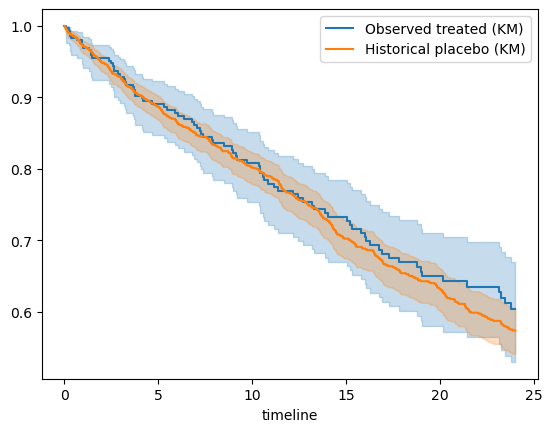

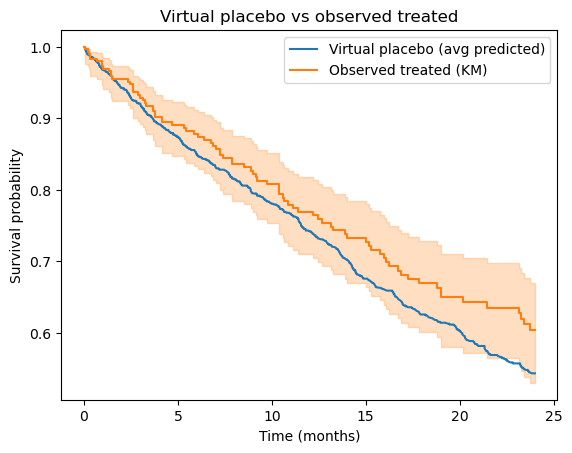

In [21]:

# Plot curves
plt.figure()
km_treated.plot_survival_function()
km_hist.plot_survival_function()
# plt.plot(avg_virtual_placebo_surv.index, avg_virtual_placebo_surv.values, label="Virtual placebo (avg predicted)")

plt.figure()
plt.plot(avg_virtual_placebo_surv.index, avg_virtual_placebo_surv.values, label="Virtual placebo (avg predicted)")
km_treated.plot_survival_function()
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Survival probability")
plt.title("Virtual placebo vs observed treated")
plt.show()


In [22]:

# -----------------------------
# 4) Compare using RMST up to tau (e.g., 24 months)
# -----------------------------
tau = 24.0

# RMST for observed treated KM
rmst_treated = restricted_mean_survival_time(km_treated, t=tau)

# RMST for virtual placebo average curve:
# lifelines RMST utility expects a fitted model or a survival function;
# easiest: approximate RMST by numerical integration (trapezoid rule).
rmst_virtual_placebo = np.trapz(avg_virtual_placebo_surv.values, avg_virtual_placebo_surv.index)

print(f"\nRMST (0 to {tau} months)")
print(f"Observed treated RMST: {rmst_treated:.2f} months")
print(f"Virtual placebo RMST:  {rmst_virtual_placebo:.2f} months")
print(f"RMST gain (treated - virtual placebo): {rmst_treated - rmst_virtual_placebo:.2f} months")



RMST (0 to 24.0 months)
Observed treated RMST: 18.70 months
Virtual placebo RMST:  17.90 months
RMST gain (treated - virtual placebo): 0.80 months


/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_55144/1217465513.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmst_virtual_placebo = np.trapz(avg_virtual_placebo_surv.values, avg_virtual_placebo_surv.index)


In [23]:

# -----------------------------
# 5) Individual-level virtual placebo: predicted median survival for each treated patient
# -----------------------------
# Median survival time = smallest t such that S(t) <= 0.5
def median_from_surv_curve(s):
    # s: array of survival probabilities over time grid
    # returns np.nan if never drops below 0.5 within grid
    idx = np.where(s <= 0.5)[0]
    return np.nan if len(idx) == 0 else float(avg_virtual_placebo_surv.index[idx[0]])

# Better: compute median for each individual's curve
time_grid = surv_funcs.index.values
ind_medians = []
for col in surv_funcs.columns:
    s = surv_funcs[col].values
    idx = np.where(s <= 0.5)[0]
    ind_medians.append(np.nan if len(idx) == 0 else float(time_grid[idx[0]]))

treated_virtual_median = np.nanmedian(ind_medians)
print(f"\nMedian predicted placebo survival (treated patients, virtual): {treated_virtual_median:.2f} months")

# Observed treated median (KM)
treated_obs_median = km_treated.median_survival_time_
print(f"Observed treated median survival (KM): {treated_obs_median:.2f} months")



Median predicted placebo survival (treated patients, virtual): 16.48 months
Observed treated median survival (KM): inf months


### A simple model validation: “Does the placebo model predict placebo?”

In [24]:
from sklearn.model_selection import train_test_split

# Split placebo data
train_df, test_df = train_test_split(hist_placebo, test_size=0.3, random_state=1)


In [25]:

cph2 = CoxPHFitter()
cph2.fit(train_df[["time", "event", "age", "sev", "sex"]], duration_col="time", event_col="event")


<lifelines.CoxPHFitter: fitted with 1050 total observations, 725 right-censored observations>

In [26]:

# Predict survival for placebo test patients and average it
test_surv = cph2.predict_survival_function(test_df[["age", "sev", "sex"]])
avg_pred = test_surv.mean(axis=1)
avg_pred

0.006144     1.000000
0.031400     0.999061
0.035266     0.998121
0.038402     0.998121
0.056132     0.997181
               ...   
23.691844    0.575248
23.716671    0.575248
23.840302    0.573002
23.932084    0.573002
24.000000    0.573002
Length: 788, dtype: float64

In [27]:

# Observed KM in placebo test set
km_test = KaplanMeierFitter().fit(test_df["time"], test_df["event"], label="Observed placebo test (KM)")
km_test

<lifelines.KaplanMeierFitter:"Observed placebo test (KM)", fitted with 450 total observations, 325 right-censored observations>

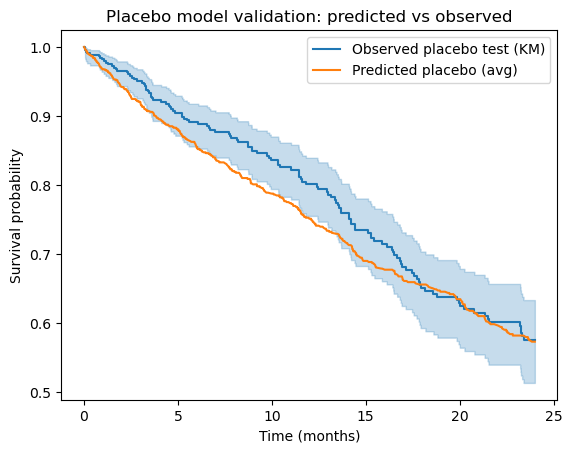

In [28]:

plt.figure()
km_test.plot_survival_function()
plt.plot(avg_pred.index, avg_pred.values, label="Predicted placebo (avg)")
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Survival probability")
plt.title("Placebo model validation: predicted vs observed")
plt.show()


In [29]:

# RMST comparison as a calibration-ish summary
tau = 24.0
rmst_obs = restricted_mean_survival_time(km_test, t=tau)
rmst_pred = np.trapz(avg_pred.values, avg_pred.index)
print(f"RMST observed placebo test: {rmst_obs:.2f}, RMST predicted: {rmst_pred:.2f}")


RMST observed placebo test: 18.87, RMST predicted: 18.22


/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_55144/935023316.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmst_pred = np.trapz(avg_pred.values, avg_pred.index)


### If you do have a small randomized placebo group, you can “augment” it

In [30]:
# Imagine your current trial has BOTH:
# treated arm (treated)
# small placebo arm (placebo_small)

placebo_small = simulate_time_to_event(n=80, beta=beta_placebo, hazard_scale=0.02, admin_censor_time=24)
placebo_small.head(3)

,time,event,age,sev,sex
0,12.764382,0,64.082538,-0.311726,1
1,17.248432,1,48.384349,1.462317,1
2,11.560555,1,77.976998,-0.728445,1


In [31]:

km_small_placebo = KaplanMeierFitter().fit(placebo_small["time"], placebo_small["event"], label="Observed placebo (small KM)")
km_treated = KaplanMeierFitter().fit(treated["time"], treated["event"], label="Observed treated (KM)")


In [32]:

# virtual placebo predictions for treated patients (as above)
surv_funcs = cph.predict_survival_function(treated[["age", "sev", "sex"]])
avg_virtual_placebo_surv = surv_funcs.mean(axis=1)


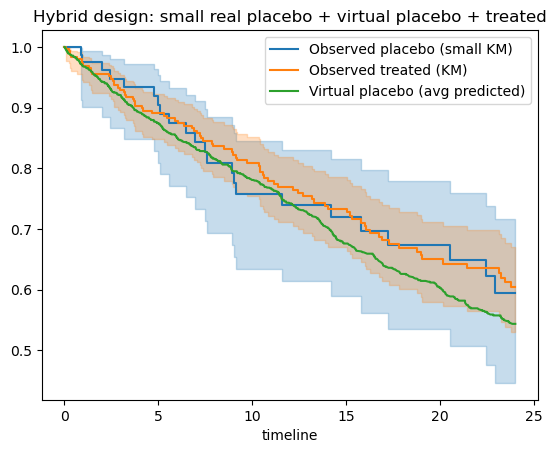

In [33]:

plt.figure()
km_small_placebo.plot_survival_function()
km_treated.plot_survival_function()
plt.plot(avg_virtual_placebo_surv.index, avg_virtual_placebo_surv.values, label="Virtual placebo (avg predicted)")
plt.legend()
plt.title("Hybrid design: small real placebo + virtual placebo + treated")
plt.show()
